In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

y = h5py.File('P300.mat', 'r')

fs = 256
eeg_ch = np.arange(8)

In [2]:
data = y['y'].value
y.keys()

/home/nekketsu/anaconda3/envs/tensorflow-gpu/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


<KeysViewHDF5 ['y']>

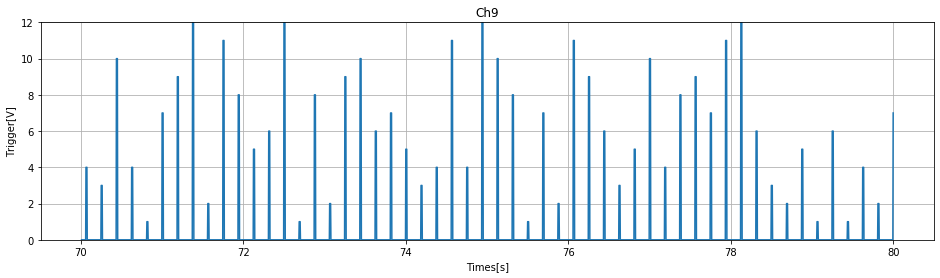

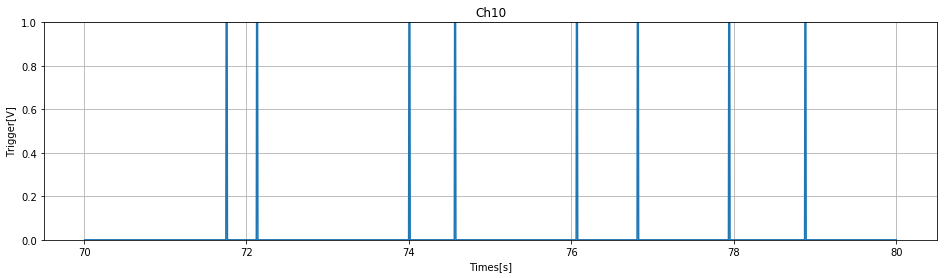

In [3]:
############ 最初の10秒分を削除
data2 = data[256 * 10 + 1: len(data), :]

###Ch9の60～70秒のデータ表示
plt.figure(figsize=(16,4))
plt.ylim(0,12)
plt.title("Ch9")
plt.xlabel("Times[s]")
plt.ylabel("Trigger[V]")
plt.grid(True)
plt.plot(data2[60 * fs + 1:70 * fs, 0],data2[60 * fs + 1:70 * fs,9])

###Ch10の60～70秒のデータ表示
plt.figure(figsize=(16,4))
plt.ylim(0,1)
plt.title("Ch10")
plt.xlabel("Times[s]")
plt.ylabel("Trigger[V]")
plt.grid(True)
plt.plot(data2[60 * fs + 1:70 * fs, 0],data2[60 * fs + 1:70 * fs,10])


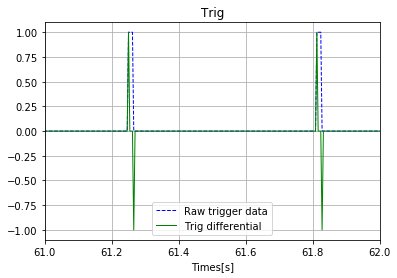

In [4]:
#############ターゲット刺激トリガデータの時間差分データを作る
tmp = data2[1:len(data2), 10] - data2[0:len(data2) - 1,10]

###データ長を合わせるために0を挿入
tdiff = np.insert(tmp, 0, 0)

plt.xlim(61,62)
plt.title("Trig")
plt.xlabel("Times[s]")
plt.grid(True)

###グラフの表示
plt.plot(data2[:,0],data2[:,10],color='blue',  linestyle='dashed', linewidth = 1.0, label="Raw trigger data") ##元のトリガ信号
plt.plot(data2[:,0],tdiff,color='green',  linestyle='solid', linewidth = 1.0, label="Trig differential") ##時間差分データ
plt.legend()

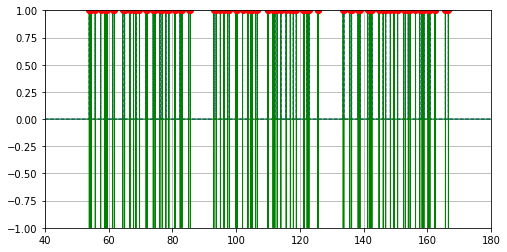

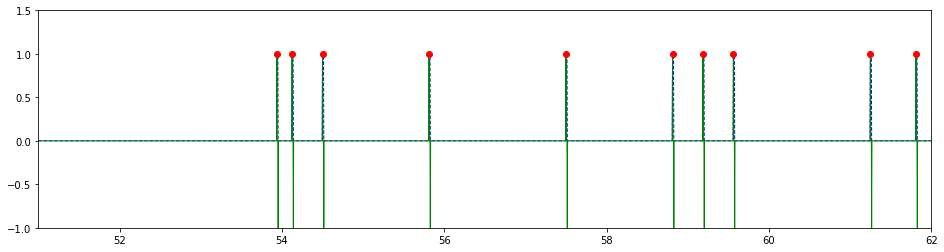

In [5]:
%matplotlib inline
ttrig = np.where(tdiff > 0.8) #tdiff内で0.8より多きい要素の位置をttrigに入れる
ttrig = np.array(ttrig).reshape((-1))
plt.figure(figsize=(8,4))
plt.xlim(40,180)
plt.ylim(-1,1)
plt.grid()
plt.plot(data2[:,0],data2[:,10],color='blue',  linestyle='dashed', linewidth = 1.0, label="Raw trigger data") #ttrigの立ち上がりの時間を表示
plt.plot(data2[:,0],tdiff,color='green',  linestyle='solid', linewidth = 1.0, label="wakaran") #ターゲット刺激に対するトリガのインデックスが抽出できたかの確認
plt.plot(data2[ttrig,0],data2[ttrig,10], color='red',  linestyle='none', marker = 'o')

plt.figure(figsize=(16,4))
plt.xlim(51,62)
plt.ylim(-1,1.5)
plt.plot(data2[:,0],data2[:,10],color='blue',  linestyle='dashed', linewidth = 1.0, label="Raw trigger data") #ttrigの立ち上がりの時間を表示
plt.plot(data2[:,0],tdiff,color='green',  linestyle='solid', linewidth = 1.0, label="wakaran") #ターゲット刺激に対するトリガのインデックスが抽出できたかの確認
plt.plot(data2[ttrig,0],data2[ttrig,10], color='red',  linestyle='none', marker = 'o')

In [6]:
#### target以外のトリガの取り出し
adiff = np.array([data2[1:len(data2),9] - data2[0:len(data2) - 1 ,9]]) #Ch9のトリガデータからすべての光刺激に対するトリガを抽出
adiff = np.insert(adiff,0,0) #先頭に0を挿入
atrig = np.where(adiff > 0.8) #0.8よりも大きい数を代入

flg = np.isin(atrig,ttrig) #atrigとttrigを比較して真偽値で表す
ntrig = np.array(atrig)[np.logical_not(flg)] #falseを抽出

print(ntrig[0 : 20])
print(ttrig[0 : 10])

[10815 10863 10911 10959 11007 11055 11103 11151 11199 11343 11439 11487
 11535 11583 11631 11679 11775 11823 11871 11919]
[11247 11295 11391 11727 12159 12495 12591 12687 13119 13263]


In [7]:
# data内のtriggerで示される刺激を基準に刺激前-0.1s, 刺激後0.7sのデータを切り出し，加算平均を行う
import numpy as np
def average_wave(data , trigger):
    NCh = 8 #脳波のチャンネル数
    before_time = 0.1 #トリガの前から0.1s = 100msのデータを取る
    after_time = 0.7 #トリガ後は700msとる
    
    tt = np.arange(-1 * before_time , after_time, 1/fs) #加算データの時刻のインデックス
    Nave = len(trigger) #加算平均回数の指定
    print(Nave)
    ###加算平均処理
    bef = round(before_time * fs)
    aft = round(after_time * fs)

    ##加算するための変数tmpを作る
    tmp = np.zeros((len(tt), NCh))
    for ii in range(Nave):
        tmp = tmp + data[trigger[ii] - bef : trigger[ii] + aft, 1 : NCh + 1]
        
    averaged = tmp / Nave

    ###ベースライン処理
    averaged = averaged - averaged[bef,:]
    return averaged

90
450
(205,)


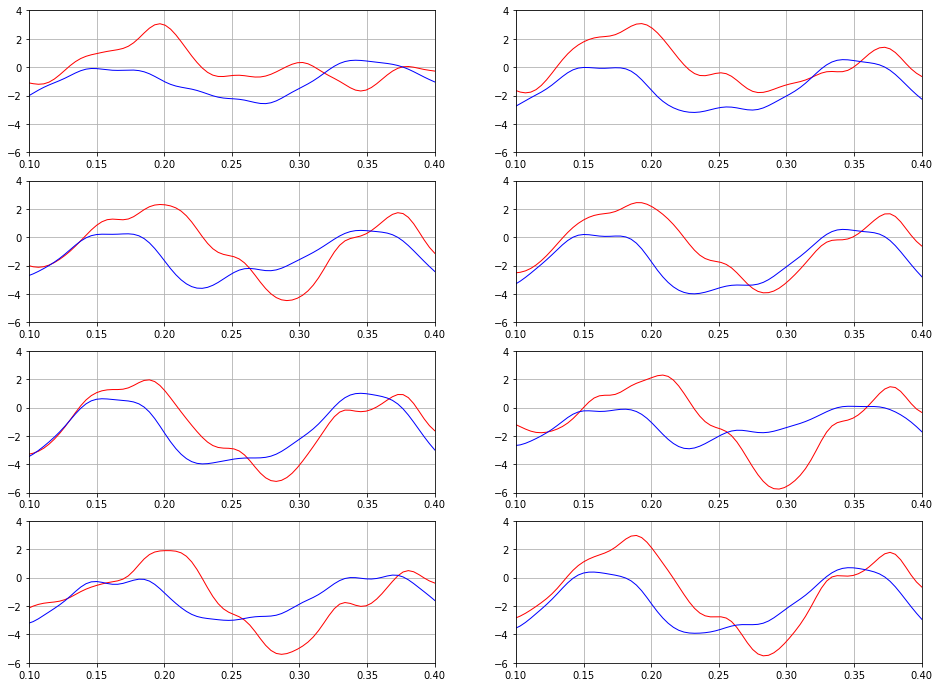

In [8]:
target = average_wave(data2,ttrig)
non_target = average_wave(data2, ntrig)
tt = np.arange(-0.1 , 0.7, 1./256.0)
print(tt.shape)

plt.figure(figsize=(16,12))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.plot(tt, target[:,i], color='red',  linestyle='solid', linewidth = 1.0, label="all")
    plt.plot(tt, non_target[:,i], color='blue',  linestyle='solid', linewidth = 1.0, label="all")
    plt.xlim((0.1, 0.4))
    plt.ylim((-6, 4))
    plt.grid()

In [9]:
def pick_waves(data , trigger, pickCh, before_time=-0.1, after_time=0.405):
    # before_time = 0.1 #トリガの前から0.1s = 100sのデータを取る
    # after_time = 0.7 #トリガ後は700sとる
    
    trigger = np.array(trigger)

    Nave = len(trigger) #加算平均回数の指定
    
    ###ポイント数の計算
    bef = round(before_time * fs)
    aft = round(after_time * fs)

    ##波形を取り出す変数pick_epochを作る
    tt = np.arange(0.1, 0.4, 1./256.0)
#     print(Nave, len(tt))

    pick_epoch = np.zeros((len(tt)+1, Nave))
    for ii in range(Nave):
        pick_epoch[:,ii] = data[trigger[ii] - bef : trigger[ii] + aft, pickCh]

    return pick_epoch

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# targetデータの取り出し
X_target = pick_waves(data2, ttrig, 3)
X_target = X_target.transpose()
N_target = len(ttrig)
Y_target = np.ones((N_target,)).astype(np.int32)
print(np.array(X_target).shape)

# non-targetデータの取り出し
X_nontarget = pick_waves(data2,ntrig, 3)
X_nontarget = X_nontarget.transpose()
N_nontarget = len(ntrig)
Y_nontarget = np.zeros((N_nontarget,)).astype(np.int32)
print(np.array(X_nontarget).shape)
print(np.array(Y_nontarget).shape)

for i in [5, 6, 7, 8]:
    X_tmp_target = pick_waves(data2, ttrig, i)
    X_tmp_target = X_tmp_target.transpose()
#     N_target = len(ttrig)
#     Y_target = np.ones((N_target,)).astype(np.int32)
    X_target = np.dstack([X_target, X_tmp_target])
    print(np.array(X_target).shape)

    # non-targetデータの取り出し
    X_tmp_nontarget = pick_waves(data2,ntrig, i)
    X_tmp_nontarget = X_tmp_nontarget.transpose()
#     N_nontarget = len(ntrig)
#     Y_nontarget = np.zeros((N_nontarget,)).astype(np.int32)
    X_nontarget = np.dstack([X_nontarget, X_tmp_nontarget])
    print(np.array(X_nontarget).shape)
    print(np.array(Y_nontarget).shape)

# データの結合
X_tmp = np.concatenate([X_target, X_nontarget], axis = 0)
Y_tmp = np.concatenate([Y_target, Y_nontarget], axis = 0)
#Y_tmp = np.identity(2)[Y_tmp]
print(X_tmp.shape, Y_tmp.shape)

(90, 78)
(450, 78)
(450,)
(90, 78, 2)
(450, 78, 2)
(450,)
(90, 78, 3)
(450, 78, 3)
(450,)
(90, 78, 4)
(450, 78, 4)
(450,)
(90, 78, 5)
(450, 78, 5)
(450,)
(540, 78, 5) (540,)


In [12]:
# # 同じ時刻のポイントのチャンネル平均とる
# X_tmp = np.average(X_tmp, axis=2)
# X_tmp.shape

In [13]:
# from sklearn.preprocessing import StandardScaler
# std = StandardScaler()
# X_tmp = std.fit_transform(X_tmp)

# ３次元のときの標準化
import scipy.stats
X_tmp = scipy.stats.zscore(X_tmp)

In [14]:
X_tmp

array([[[ 1.25599697,  0.99956505,  2.06413459,  1.15237981,
          1.09899946],
        [ 1.4683053 ,  1.14975559,  2.28941421,  1.52374942,
          1.32394776],
        [ 1.61382795,  1.2915394 ,  2.34789404,  1.79367807,
          1.51014248],
        ...,
        [ 2.5990508 ,  2.15212889,  2.6813393 ,  3.64816993,
          2.57377245],
        [ 2.67855028,  2.1814305 ,  2.79913868,  3.70435004,
          2.5138012 ],
        [ 2.7537357 ,  2.18988331,  2.91252916,  3.7028    ,
          2.41916213]],

       [[ 1.04476453,  1.13840465,  0.72849855,  1.28609147,
          0.88343542],
        [ 1.11173849,  1.29375651,  0.78663321,  1.33228054,
          1.01376306],
        [ 1.23755688,  1.52696534,  0.91265722,  1.51000912,
          1.22029212],
        ...,
        [-0.57055153, -0.35957969, -0.2376797 ,  0.07357686,
         -0.06817975],
        [-0.59673735, -0.42910293, -0.25384706,  0.05442719,
         -0.1292216 ],
        [-0.57588998, -0.4430092 , -0.21251875, 

(78, 5) (540, 78, 5) (540,)


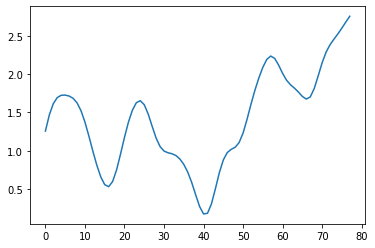

8.063614142766569e-18


In [15]:
plt.plot(X_tmp[0, :, 0])
print(X_tmp[0].shape, X_tmp.shape, Y_tmp.shape)
plt.show()
print(X_tmp.mean())

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tmp, Y_tmp,
                                                    test_size=0.3, random_state = 1)

In [17]:
# 訓練データのターゲットと非ターゲットの割合を同じにする
target_index = np.where(Y_train==1)[0]
print(X_train[target_index].shape, Y_train[target_index])
for i in range(4):
    X_train = np.concatenate([X_train, X_train[target_index]])
    Y_train = np.concatenate([Y_train, Y_train[target_index]])

# Accuracyの見栄えが良くなるのでtestデータも複製しとく
target_index = np.where(Y_test==1)[0]
for i in range(4):
    X_test = np.concatenate([X_test, X_test[target_index]])
    Y_test = np.concatenate([Y_test, Y_test[target_index]])

(63, 78, 5) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [18]:
# データの水増し（水平シフト）
import random
X_list = []
Y_list = []
for roop_count in range(5):
    X_tmp_tmp = np.roll(X_train, random.randint(5, 25), axis=1)
    X_list.append(X_tmp_tmp)
    Y_list.append(Y_train)

for X_tmp_tmp, Y_tmp_tmp in zip(X_list, Y_list):
    X_train = np.concatenate([X_train, X_tmp_tmp], axis = 0)
    Y_train = np.concatenate([Y_train, Y_tmp_tmp], axis = 0)
del X_list, Y_list, X_tmp_tmp

In [19]:
# X_train[0,:,:]

In [20]:
# データの水増し(垂直シフト)
import random
X_list = []
Y_list = []
for roop_count in range(5):
    X_tmp_tmp = np.zeros(X_train.shape)
    for i in range(X_train.shape[0]):
        X_tmp_tmp[i, :] = X_train[i, :] + random.uniform(-0.5, 0.5)
    X_list.append(X_tmp_tmp)
    Y_list.append(Y_train)
for X_tmp_tmp, Y_tmp_tmp in zip(X_list, Y_list):
    X_train = np.concatenate([X_train, X_tmp_tmp], axis = 0)
    Y_train = np.concatenate([Y_train, Y_tmp_tmp], axis = 0)
del X_list, Y_list, X_tmp_tmp

In [21]:
# X_train = X_train.reshape(-1, X_train.shape[1], 1)
# X_test  = X_test.reshape(-1, X_test.shape[1], 1)
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test  = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)
X_train = (X_train).astype(np.float32)
X_test  = (X_test).astype(np.float32)
Y_train = (Y_train).astype(np.int32)
Y_test  = (Y_test).astype(np.int32)

In [22]:
X_train.shape, Y_train.shape

((22680, 78, 5, 1), (22680, 1))

In [23]:
threshold = 0.5
def mcc_metric(y_true, y_pred):
    predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [30]:
from tensorflow.keras import layers
from tensorflow.keras.initializers import he_normal

model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), kernel_initializer=he_normal()))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2), padding='same'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.75))
model.add(layers.BatchNormalization())
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', mcc_metric])

In [31]:
history = model.fit(X_train, Y_train, epochs=30, batch_size=512, validation_data=(X_test, Y_test))

Train on 22680 samples, validate on 270 samples
Epoch 1/30
22680/22680 [==============================] - 1s 56us/sample - loss: 0.6844 - acc: 0.6217 - mcc_metric: 0.0000e+00 - val_loss: 1.8679 - val_acc: 0.4185 - val_mcc_metric: 0.0000e+00
Epoch 2/30
22680/22680 [==============================] - 0s 16us/sample - loss: 0.5078 - acc: 0.7399 - mcc_metric: 0.0000e+00 - val_loss: 2.0661 - val_acc: 0.4704 - val_mcc_metric: 0.0000e+00
Epoch 3/30
22680/22680 [==============================] - 0s 19us/sample - loss: 0.3356 - acc: 0.8499 - mcc_metric: 0.0000e+00 - val_loss: 1.6703 - val_acc: 0.5148 - val_mcc_metric: 0.0000e+00
Epoch 4/30
22680/22680 [==============================] - 0s 18us/sample - loss: 0.2098 - acc: 0.9142 - mcc_metric: 0.0000e+00 - val_loss: 1.5095 - val_acc: 0.6037 - val_mcc_metric: 0.0000e+00
Epoch 5/30
22680/22680 [==============================] - 0s 16us/sample - loss: 0.1442 - acc: 0.9443 - mcc_metric: 0.0000e+00 - val_loss: 2.5944 - val_acc: 0.5556 - val_mcc_metric

In [32]:
model.evaluate(X_test, Y_test)

270/270 [==============================] - 0s 368us/sample - loss: 8.2960 - acc: 0.5000 - mcc_metric: nan


[8.296012737132886, 0.5, nan]

In [33]:
pred = model.predict_classes(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred)

array([[125,  10],
       [125,  10]])

In [34]:
pred = model.predict_classes(X_train)
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_train, pred).ravel()
(tn, fp, fn, tp)

(11340, 0, 2, 11338)

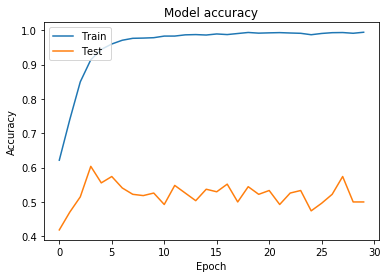

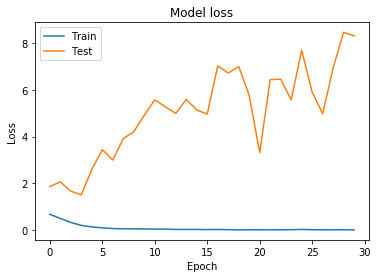

In [35]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()